In [3]:
#!/usr/bin/env Rscript

# Functions
## cluster peaks by k-means
km1d <- function(x_ma, k=2) {
    o_ma <- NULL
    for (i in 1:ncol(x_ma)) {
        # cluster by k-means
        km <- Ckmeans.1d.dp(x_ma[, i], k)
        km_df <- data.frame(x = x_ma[, i], cluster = km$cluster)
        km_df <- km_df[order(km_df[,1]), ]
        km_df <- km_df[!duplicated(km_df[, 'cluster']), ]
        # min of each cluster as cutoff
        km_min <- km_df[-1, 1]
        # output
        o_ma <- cbind(o_ma, km_min)
        colnames(o_ma)[i] <- colnames(x_ma)[i]
    }
    return(o_ma[1,])
}


In [11]:
AF_density <- function(af_dt, cutoff) {
    af_p <- ggplot() + 
     geom_density(aes(x = value, fill = variable), 
     data = af_dt, alpha = 0.5, show.legend = FALSE) + 
     geom_vline(aes(xintercept = cutoff),
     data = af_dt, linetype='dashed', color = 'red', linewidth = 0.5) + 
     scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2),
     expand = expansion(mult = c(0, 0))) + 
     scale_y_continuous(limits = c(0, 10), breaks = seq(0, 10, 2),
     expand = expansion(mult = c(0, 0))) + 
     facet_wrap(~ variable, scales = "free") + 
     theme(plot.margin = unit(c(1, 1, 1, 1), 'cm'), plot.background = element_blank(),
     axis.line = element_blank(), 
     axis.ticks = element_line(colour = 'black', linewidth  = 0.5), 
     axis.text = element_text(color = 'black'), axis.title = element_blank(), 
     panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     panel.background = element_blank())
    return(af_p)
}

In [46]:
counts_bar <- function(counts_df, y_breaks) {
    ggplot(data=counts_df, aes(x=N_samples, y=N_truncal_SNVs)) +
     geom_bar(stat="identity") + 
     scale_y_continuous(limits = c(min(y_breaks), max(y_breaks)), breaks = y_breaks,
      expand = expansion(mult = c(0, 0))) + 
     theme(plot.margin = unit(c(1, 1, 1, 1), 'cm'), plot.background = element_blank(),
     axis.line.y = element_line(colour = 'black', linewidth  = 0.5), 
     axis.ticks = element_line(colour = 'black', linewidth  = 0.5), 
     axis.ticks.length.y = unit(0.2, 'cm'), 
     axis.text = element_text(color = 'black'), axis.title = element_blank(), 
     panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     panel.background = element_blank())
}

In [587]:

# MLE for pattern
MLE_pattern <- function(pattern, model=NULL, error) {
    # pattern (pattern x sample) in data.table format
    ## a binary matrix in which each row is a binary pattern, each column is a sample
    ## the 1st column must be pattern_id
    # model (model x sample) in data.table format
    ## a binary matrix in which each row is a binary model, each column is a sample
    ## the 1st column must be model_id
    # errors (sample x error rate)
    ## a fractional matrix in which each row is a sample, columns inclue FNR, TPR, FPR and TNR

    # generate exhaustive models if no input models
    if (is.null(model)) {
        model <- data.table(expand.grid(rep(list(0:1), ncol(pattern[, -1]))))
        colnames(model) <- colnames(pattern[, -1])
        model[, model_id := paste0('model_', 1:nrow(model))]
    }
    # convert model to long dt
    model <- melt(data = model, id.vars=c('model_id'), 
      variable.name = 'sample', value.name = 'model')

    MLE_dt <- data.table()
    for (model_i in 1:nrow(pattern)) {
        # genereate a dt of the current model
        model_i_ma <- as.matrix(t(pattern[model_i, -1]))
        model_i_dt <- data.table(sample = rownames(model_i_ma), 
                                 pattern_id=as.matrix(t(pattern[model_i, 1]))[1 ,1], 
                                 pattern=model_i_ma[, 1])
        # integrate with all possible models
        model_i_dt <- merge(model, model_i_dt, by = 'sample')
        # integrate with all probabilities
        model_i_dt <- merge(model_i_dt, error, by = 'sample')
        # determine conditional probabilities
        model_i_dt[(model == 1) & (pattern == 1), P_sample := TPR]
        model_i_dt[(model == 0) & (pattern == 0), P_sample := TNR]
        model_i_dt[(model == 0) & (pattern == 1), P_sample := FPR]
        model_i_dt[(model == 1) & (pattern == 0), P_sample := FNR]
        # convert the table of sample-specific P to a matrix
        P_i_dt <- dcast(data=model_i_dt, model_id ~ sample, value.var = 'P_sample')
        rownames(P_i_dt) <- P_i_dt[, model_id]
        P_i_dt[, model_id := NULL]
        P_i_ma <- as.matrix(P_i_dt)
        rownames(P_i_ma) <- rownames(P_i_dt)
        # Maximum likelihood estimation (MLE)
        L_i <- apply(P_i_ma, MARGIN = 1, FUN = prod)
        # extract relavent infomation
        L_i_max <- max(L_i) # maximum likelihood
        model_i_ML <- names(which.max(L_i)) # combination with maximum likelihood
        model_im_dt <- model_i_dt[model_id == model_i_ML] # subset the main table based on combination with maximum likelihood
        # extract relavent infomation
        model_im_dt[, L_model := L_i_max]
        model_im_dt[, M_model := ifelse(model == pattern, 0, 1)]
        # merge into the main output
        MLE_dt <- rbind(MLE_dt, model_im_dt)
    }
    return(MLE_dt)
}


In [588]:
# define colors
gray01_fun = colorRamp2(c(0, 1), c( "white", "black"))

In [2]:
# libraries
library(data.table)
library(vcfR)
library(ggplot2)
library(Ckmeans.1d.dp)
library(UpSetR)
library(ComplexHeatmap)
library(circlize)
library(ape)


   *****       ***   vcfR   ***       *****
   This is vcfR 1.14.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circliz

In [4]:
# input
i <- '~/Dropbox (Partners HealthCare)/projects/Kidney_Cancer_Translocation/WGS analysis/TRCC18/FinalData/SNV_filtered_vcf/TRCC18.HC_M2.final.vcf.gz'
o <- '~/Dropbox (Partners HealthCare)/projects/Kidney_Cancer_Translocation/WGS analysis/TRCC18/FinalData/SNV_ptree_ma/TRCC18.ptree.'
min_ad2 <- 2
pw <- 7
ph <- 7

snv_vcf <- read.vcfR(i)


Scanning file to determine attributes.
File attributes:
  meta lines: 277
  header_line: 278
  variant count: 4311
  column count: 26
Meta line 277 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 4311
  Character matrix gt cols: 26
  skip: 0
  nrows: 4311
  row_num: 0
Processed variant: 4311
All variants processed


In [5]:
# generate matrices from input VCF
## extract AD matrix from VCF
ad_ma <- extract.gt(snv_vcf, element = 'AD')
## reorder rows by chr_pos
ad_rn <- rownames(ad_ma)
ad_rn <- t(sapply(strsplit(ad_rn, "_"), unlist))
ad_rn <- ad_rn[order(ad_rn[, 1], as.integer(ad_rn[,2])),]
ad_rn <- paste(ad_rn[, 1], ad_rn[ ,2], sep = '_')
ad_ma <- ad_ma[ad_rn, ]
## reorder columns by samples
sample_order <- c('B_TRCC_18_Normal', 
 'LiverNormal', 'KidneyNormal',
 'B_TRCC_18_Tumor', 'LeftMedLNTum_1',
 'LiverTum_1', 'LiverTum_2', 'LiverTum_3', 
 'LiverTum_4', 'LiverTum_5', 'LiverTum_6',
 'LungPlTum_1', 'LungPlTum_2', 'LungPlTum_3',
 'RPLNTum_1', 'RPLNTum_2', 'RPLNTum_3'
)
ad_ma <- ad_ma[, sample_order]
## calculate allelic fraction
ad1_ma <- masplit(ad_ma, sort = 0, record = 1)
ad2_ma <- masplit(ad_ma, sort = 0, record = 2)
dp_ma <- ad1_ma + ad2_ma
dp_ma[dp_ma == 0] <- 1
af_ma <- ad2_ma / dp_ma

In [7]:
# fileter
## remove normal samples from the main matrix
normal_col <- c('B_TRCC_18_Normal', 'LiverNormal', 'KidneyNormal')
ad2_ma <- ad2_ma[, !colnames(ad2_ma) %in% normal_col]
af_ma <- af_ma[, !colnames(af_ma) %in% normal_col]
## Using k-means clustering, filter SNVs with sample-specific allele frequencies below the threshold value
af_min <- km1d(af_ma, 2)
filtered_ma <- t(t(af_ma) > af_min)
filtered_ma <- (ad2_ma >= min_ad2) * (filtered_ma)
## generate a binnary matrix for sample with the detected SNVs
filtered_dt <- data.table(chr_pos = rownames(filtered_ma), filtered_ma)
### generate tables
ad2_dt <- data.table(chr_pos = rownames(ad2_ma), ad2_ma)
af_dt <- data.table(chr_pos = rownames(af_ma), af_ma)

In [50]:
# extract positions
filtered_chr <- gsub('_[0-9]*$', '', rownames(filtered_ma))
filtered_pos <- gsub('^.*_', '', rownames(filtered_ma))
filtered_site_dt <- data.table(chr=filtered_chr, pos=filtered_pos, chr_pos=rownames(filtered_ma))

In [383]:
# output tables
## write table of alt read count
fwrite(ad2_dt, paste0(o, "AD2.matrix.tsv"), sep = "\t")
## write table of allelic fraction
fwrite(af_dt, paste0(o, "AF.matrix.tsv"), sep = "\t")
## write binnary matrix for sample with the detected SNVs
fwrite(filtered_dt, paste0(o, "SNV.matrix.tsv"), sep = "\t")

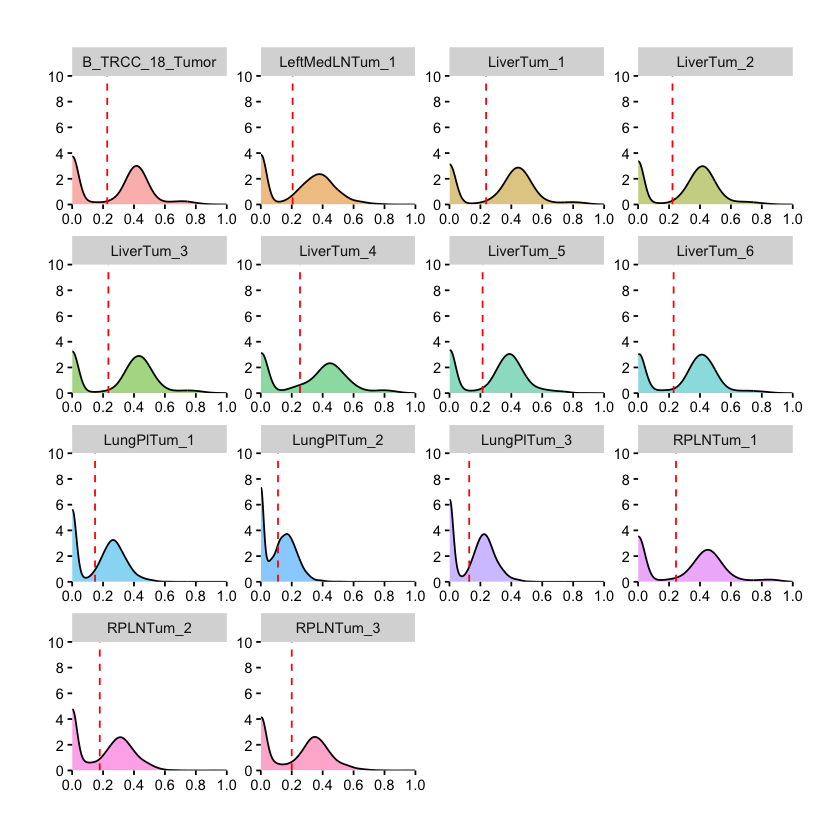

In [12]:
# plot allelic fraction distribution for all SNVs
## convert the matrix to a LONG data.table by melt for ggplot2
af_ldt <- melt(af_dt, id = 1, variable.name = "variable")
af_ldt <- af_ldt[, cutoff := af_min[variable]]
## generate plot element using ggplot
(af_p <- AF_density(af_ldt, cutoff))

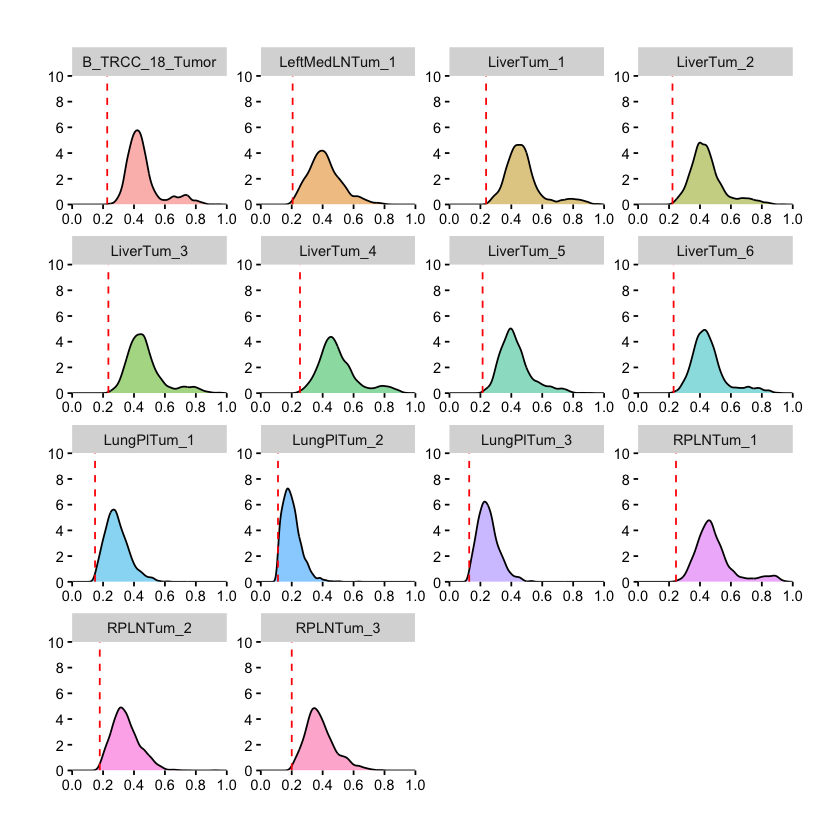

In [13]:
# plot allelic fraction distribution for truncal SNVs
## get rownames of truncal SNVs (N=14)
truncal_ma <- filtered_ma[rowSums(filtered_ma) == 14, ]
## subset the AF table
truncal_af_ldt <- af_ldt[chr_pos %in% rownames(truncal_ma)]
## plot AF distribution
(truncal_af_p <- AF_density(truncal_af_ldt, cutoff))


  0   1   2   3   4   5   6   8  12  13  14 
 26  40  40   4   6  15   2   3   5  46 176 

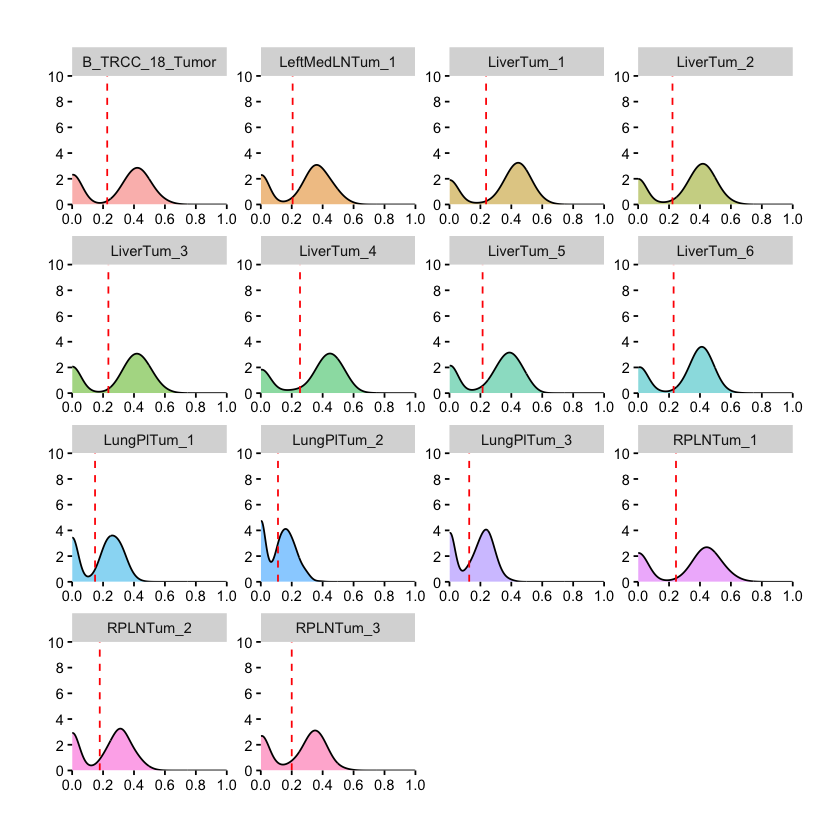

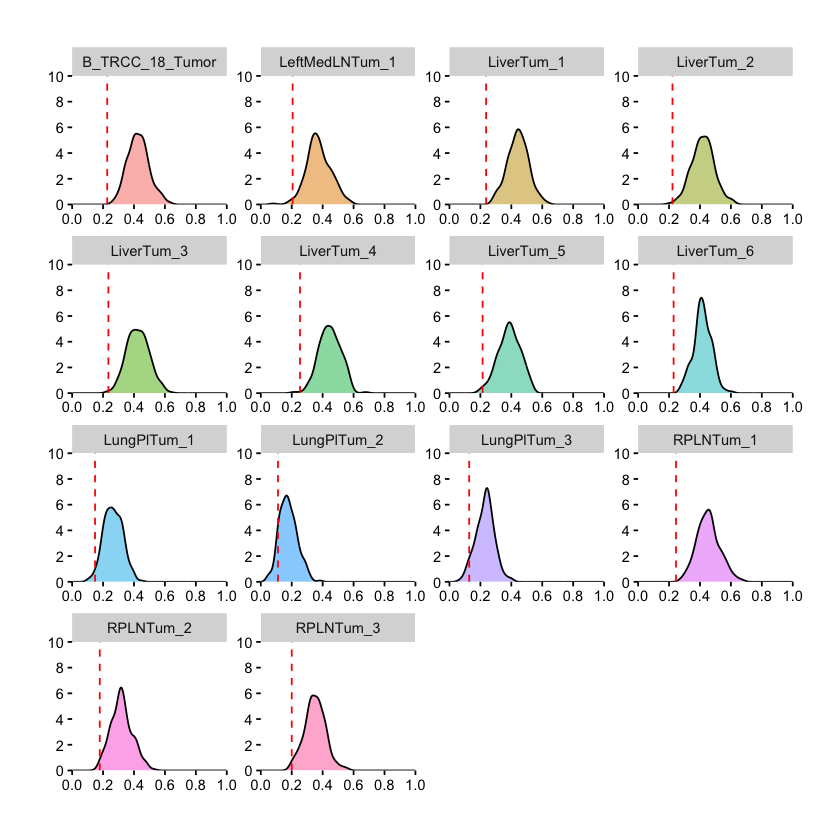

In [15]:
# determine truncal SNVs based on chr2 (Assupmtion: most SNVs on chr2 should be truncal SNVs)
## calculate frequency distribution of SNVs that are shared across different numbers of samples
chr2_filtered_ma <- filtered_ma[rownames(filtered_ma) %like% 'chr2_', ]
table(rowSums(chr2_filtered_ma))
## Truncal SNVs are defined as the SNVs that are present in at least 10 samples.
chr2_truncal_filtered_ma <- chr2_filtered_ma[rowSums(chr2_filtered_ma) >= 10, ]
## extract truncal SNVs on chr2 and plot the AF distribution
chr2_af_ldt <- af_ldt[chr_pos %like% 'chr2_']
chr2_truncal_af_ldt <- af_ldt[chr_pos %in% rownames(chr2_truncal_filtered_ma)]
(chr2_af_p <- AF_density(chr2_af_ldt, cutoff))
(chr2_truncal_af_p <- AF_density(chr2_truncal_af_ldt, cutoff))

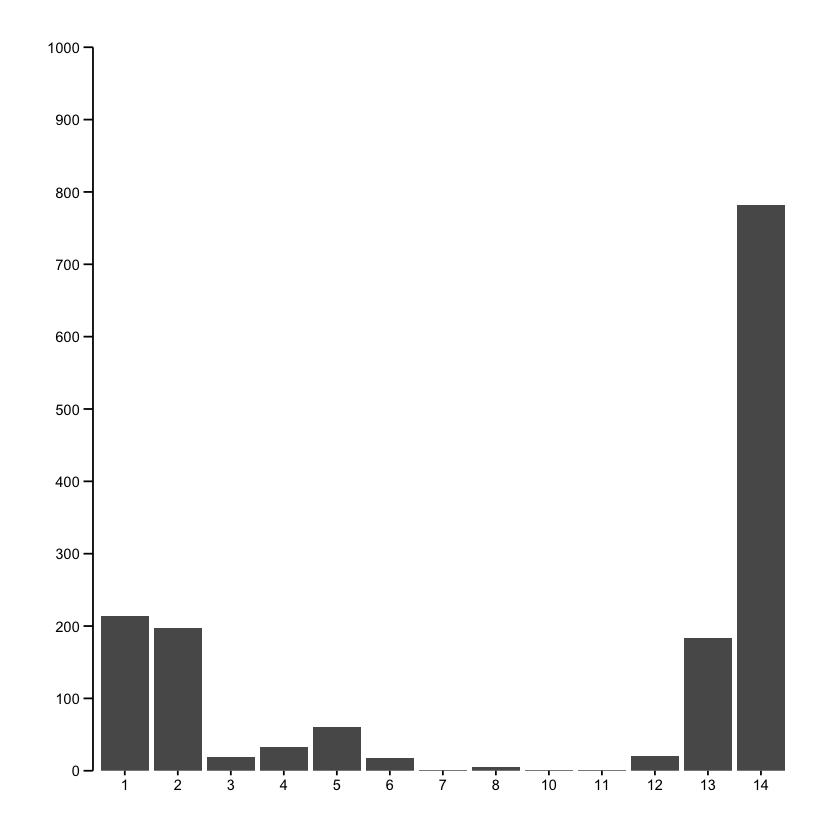

In [51]:
# make histogram of number of truncal SNVs
## extract disomic chromosomes
disomy_site_dt <- filtered_site_dt[chr %in% paste0('chr', c(2, 3, 5, 10, 12, 15, 16, 21))]
## generate a df with counts
disomy_filtered_ma <- filtered_ma[as.matrix(disomy_site_dt[,3]), ]
disomy_filtered_dt <- table(rowSums(disomy_filtered_ma))
disomy_filtered_dt <- data.table(disomy_filtered_dt)
colnames(disomy_filtered_dt) <- c('N_samples', 'N_truncal_SNVs')
disomy_filtered_dt <- disomy_filtered_dt[N_samples > 0]
disomy_filtered_df <- data.frame(disomy_filtered_dt)
## order N_samples
disomy_filtered_df$N_samples <- as.character(disomy_filtered_df$N_samples)
disomy_filtered_df$N_samples <- factor(disomy_filtered_df$N_samples, levels=disomy_filtered_df$N_samples)
## plot counts
(truncal_bar_p <- counts_bar(disomy_filtered_df, seq(0, 1000, 100)))

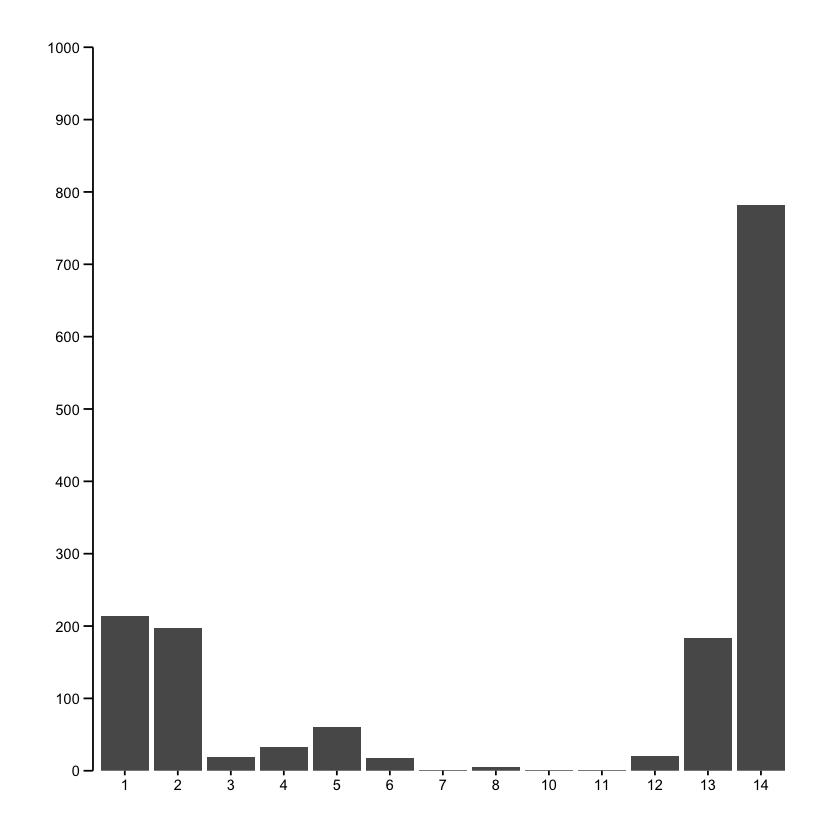

In [52]:

# fileter
## remove normal samples from the main matrix
normal_col <- c('B_TRCC_18_Normal', 'LiverNormal', 'KidneyNormal')
ad2_ma <- ad2_ma[, !colnames(ad2_ma) %in% normal_col]
af_ma <- af_ma[, !colnames(af_ma) %in% normal_col]
## Using k-means clustering, filter SNVs with sample-specific allele frequencies below the threshold value
af_min <- km1d(af_ma, 2)
filtered_k_ma <- t(t(af_ma) > af_min)
## generate a binnary matrix for sample with the detected SNVs
filtered_k_dt <- data.table(chr_pos = rownames(filtered_k_ma), filtered_k_ma)
# extract positions
filtered_k_chr <- gsub('_[0-9]*$', '', rownames(filtered_k_ma))
filtered_k_pos <- gsub('^.*_', '', rownames(filtered_k_ma))
filtered_k_site_dt <- data.table(chr=filtered_k_chr, pos=filtered_k_pos, chr_pos=rownames(filtered_k_ma))
## extract disomic chromosomes
disomy_site_k_dt <- filtered_k_site_dt[chr %in% paste0('chr', c(2, 3, 5, 10, 12, 15, 16, 21))]
## generate a df with counts
disomy_filtered_k_ma <- filtered_k_ma[as.matrix(disomy_site_k_dt[,3]), ]
disomy_filtered_k_dt <- table(rowSums(disomy_filtered_k_ma))
disomy_filtered_k_dt <- data.table(disomy_filtered_k_dt)
colnames(disomy_filtered_k_dt) <- c('N_samples', 'N_truncal_SNVs')
disomy_filtered_k_dt <- disomy_filtered_k_dt[N_samples > 0]
disomy_filtered_k_df <- data.frame(disomy_filtered_k_dt)
## order N_samples
disomy_filtered_k_df$N_samples <- as.character(disomy_filtered_k_df$N_samples)
disomy_filtered_k_df$N_samples <- factor(disomy_filtered_k_df$N_samples, levels=disomy_filtered_k_df$N_samples)
## plot counts
(truncal_bar_p <- counts_bar(disomy_filtered_k_df, seq(0, 1000, 100)))

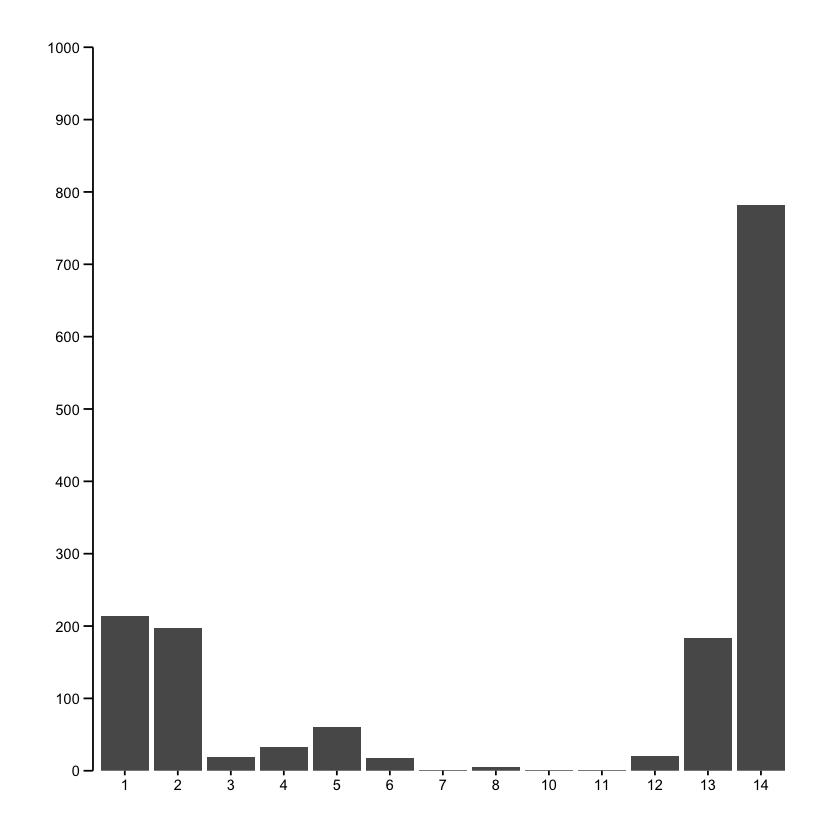

In [53]:

# fileter
## remove normal samples from the main matrix
normal_col <- c('B_TRCC_18_Normal', 'LiverNormal', 'KidneyNormal')
ad2_ma <- ad2_ma[, !colnames(ad2_ma) %in% normal_col]
af_ma <- af_ma[, !colnames(af_ma) %in% normal_col]
## Using k-means clustering, filter SNVs with sample-specific allele frequencies below the threshold value
af_min <- km1d(af_ma, 2)
filtered_k_ma <- t(t(af_ma) > 0)
filtered_k_ma <- (ad2_ma >= min_ad2) * (filtered_ma)
## generate a binnary matrix for sample with the detected SNVs
filtered_k_dt <- data.table(chr_pos = rownames(filtered_k_ma), filtered_k_ma)
# extract positions
filtered_k_chr <- gsub('_[0-9]*$', '', rownames(filtered_k_ma))
filtered_k_pos <- gsub('^.*_', '', rownames(filtered_k_ma))
filtered_k_site_dt <- data.table(chr=filtered_k_chr, pos=filtered_k_pos, chr_pos=rownames(filtered_k_ma))
## extract disomic chromosomes
disomy_site_k_dt <- filtered_k_site_dt[chr %in% paste0('chr', c(2, 3, 5, 10, 12, 15, 16, 21))]
## generate a df with counts
disomy_filtered_k_ma <- filtered_k_ma[as.matrix(disomy_site_k_dt[,3]), ]
disomy_filtered_k_dt <- table(rowSums(disomy_filtered_k_ma))
disomy_filtered_k_dt <- data.table(disomy_filtered_k_dt)
colnames(disomy_filtered_k_dt) <- c('N_samples', 'N_truncal_SNVs')
disomy_filtered_k_dt <- disomy_filtered_k_dt[N_samples > 0]
disomy_filtered_k_df <- data.frame(disomy_filtered_k_dt)
## order N_samples
disomy_filtered_k_df$N_samples <- as.character(disomy_filtered_k_df$N_samples)
disomy_filtered_k_df$N_samples <- factor(disomy_filtered_k_df$N_samples, levels=disomy_filtered_k_df$N_samples)
## plot counts
(truncal_bar_p <- counts_bar(disomy_filtered_k_df, seq(0, 1000, 100)))


In [ ]:
## extract disomic chromosomes
chr2_site_dt <- filtered_site_dt[chr %in% paste0('chr', c(2))]
## generate a df with counts
chr2_filtered_ma <- filtered_ma[as.matrix(chr2_site_dt[,3]), ]
chr2_filtered_dt <- table(rowSums(chr2_filtered_ma))
chr2_filtered_dt <- data.table(chr2_filtered_dt)
colnames(chr2_filtered_dt) <- c('N_samples', 'N_truncal_SNVs')
chr2_filtered_dt <- chr2_filtered_dt[N_samples > 0]
chr2_filtered_df <- data.frame(chr2_filtered_dt)
## order N_samples
chr2_filtered_df$N_samples <- as.character(chr2_filtered_df$N_samples)
chr2_filtered_df$N_samples <- factor(chr2_filtered_df$N_samples, levels=chr2_filtered_df$N_samples)
## plot counts
(chr2_bar_p <- counts_bar(chr2_filtered_df, seq(0, 200, 20)))


 0  1  2  3  4  5  7  8  9 10 11 12 13 14 
33 35 33  3  5  9  1  3 19 31 22  9 10 74 

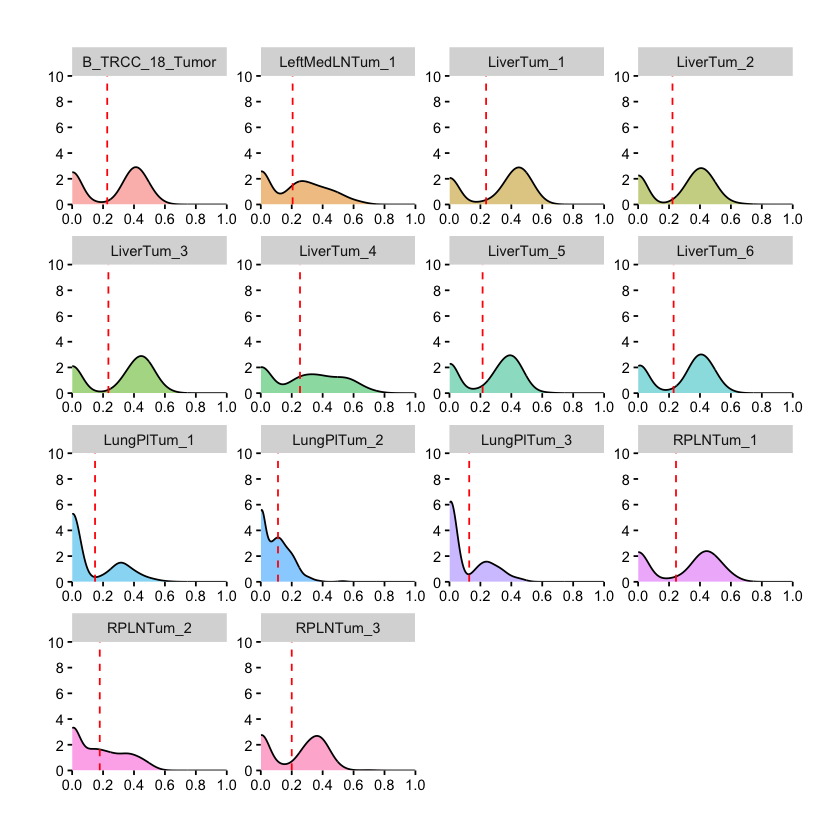

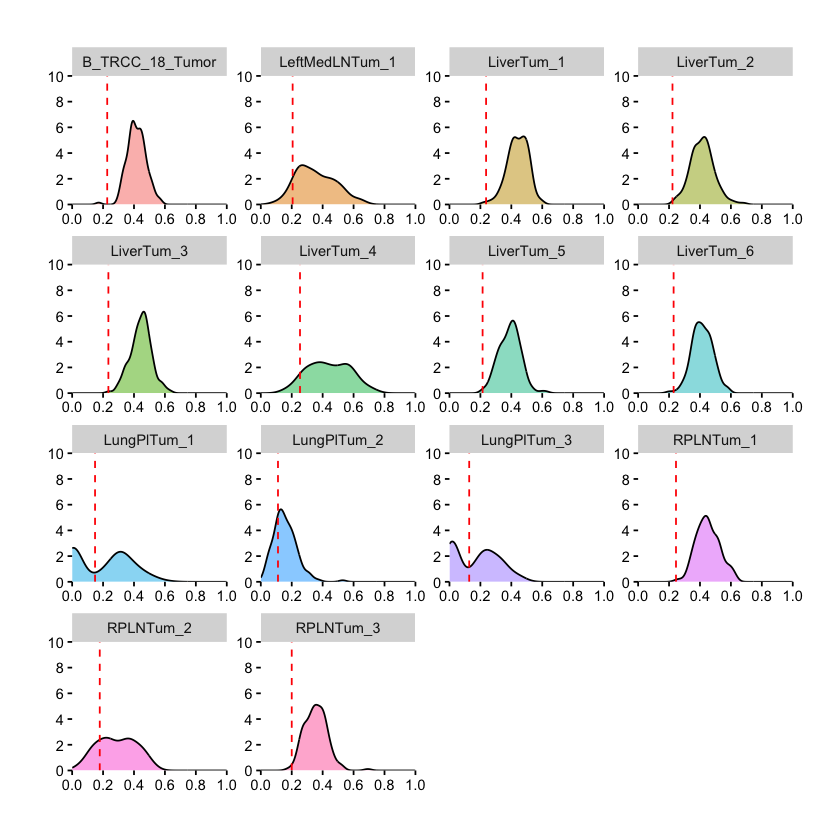

In [423]:
# determine truncal SNVs on chrX
## calculate frequency distribution of SNVs that are shared across different numbers of samples
chrX_filtered_ma <- filtered_ma[rownames(filtered_ma) %like% 'chrX_', ]
table(rowSums(chrX_filtered_ma))
## Truncal SNVs are defined as the SNVs that are present in at least 10 samples.
chrX_truncal_filtered_ma <- chrX_filtered_ma[rowSums(chrX_filtered_ma) >= 10, ]
## get allelic fraction matrix for truncal SNVs on chrX
chrX_truncal_af_ma <- af_ma[rownames(chrX_truncal_filtered_ma), ]
## extract truncal SNVs on chrX and plot the AF distribution
chrX_af_ldt <- af_ldt[chr_pos %like% 'chrX_']
chrX_truncal_af_ldt <- af_ldt[chr_pos %in% rownames(chrX_truncal_filtered_ma)]
(chrX_af_p <- AF_density(chrX_af_ldt, cutoff))
(chrX_truncal_af_p <- AF_density(chrX_truncal_af_ldt, cutoff))

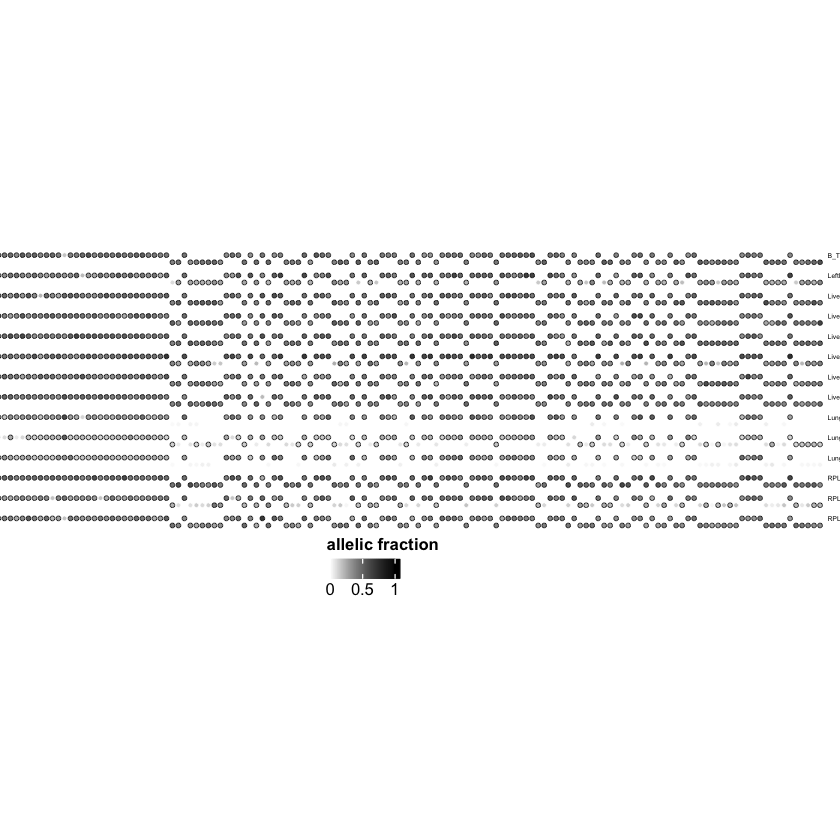

In [448]:
# plot heatmap of SNVs on chrX
## tranpose matrics for Heatmap funciton
chrX_truncal_filtered_tma <- t(chrX_truncal_filtered_ma)
chrX_truncal_af_tma <- t(chrX_truncal_af_ma)
## get SNVs presenting in at least one lung sample including LungPlTum_1 and LungPlTum_3
lung_chrX_truncal_filtered_ma <- chrX_truncal_filtered_ma[, c('LungPlTum_1', 'LungPlTum_3')]
lung_chrX_truncal_filtered <- rowSums(lung_chrX_truncal_filtered_ma)>0
lung_chrX_truncal_filtered <- rep(lung_chrX_truncal_filtered, each=nrow(chrX_truncal_af_tma))
## generate heatmap by Heatmap
chrX_truncal_af_h <- Heatmap(chrX_truncal_af_tma, name = 'allelic fraction ', 
    col = gray01_fun, rect_gp = gpar(type = "none"), 
    layer_fun = function(j, i, x, y, w=unit(0.1, 'cm'), h=unit(0.1, 'cm'), fill) {
        a = pindex(chrX_truncal_af_tma, i, j)
        b = pindex(chrX_truncal_filtered_tma, i, j)
        c0 = lung_chrX_truncal_filtered == FALSE
        c1 = lung_chrX_truncal_filtered == TRUE
        grid.circle(x = x[c0], y = y[c0] - unit(0.15, 'cm'), r = unit(0.05, 'cm'), 
            gp = gpar(lwd = 0, col = NA, fill = gray01_fun(a[c0])))
        grid.circle(x = x[c1], y = y[c1], r = unit(0.05, 'cm'), 
            gp = gpar(lwd = 0, col = NA, fill = gray01_fun(a[c1])))
        grid.circle(x = x[c0], y = y[c0] - unit(0.15, 'cm'), r = unit(0.05, 'cm'), 
            gp = gpar(lwd = 0.5, col = gray01_fun(b[c0]), fill = NA))
        grid.circle(x = x[c1], y = y[c1], r = unit(0.05, 'cm'), 
            gp = gpar(lwd = 0.5, col = gray01_fun(b[c1]), fill = NA))
    },
    cluster_rows = FALSE, cluster_columns = FALSE,
    heatmap_width = unit(20, 'cm'), heatmap_height = unit(6, 'cm'),
    show_row_names = TRUE, show_column_names = FALSE,
    row_names_gp = gpar(fontsize = 4),
    heatmap_legend_param = list(direction = 'horizontal'))

draw(chrX_truncal_af_h, heatmap_legend_side = "bottom")


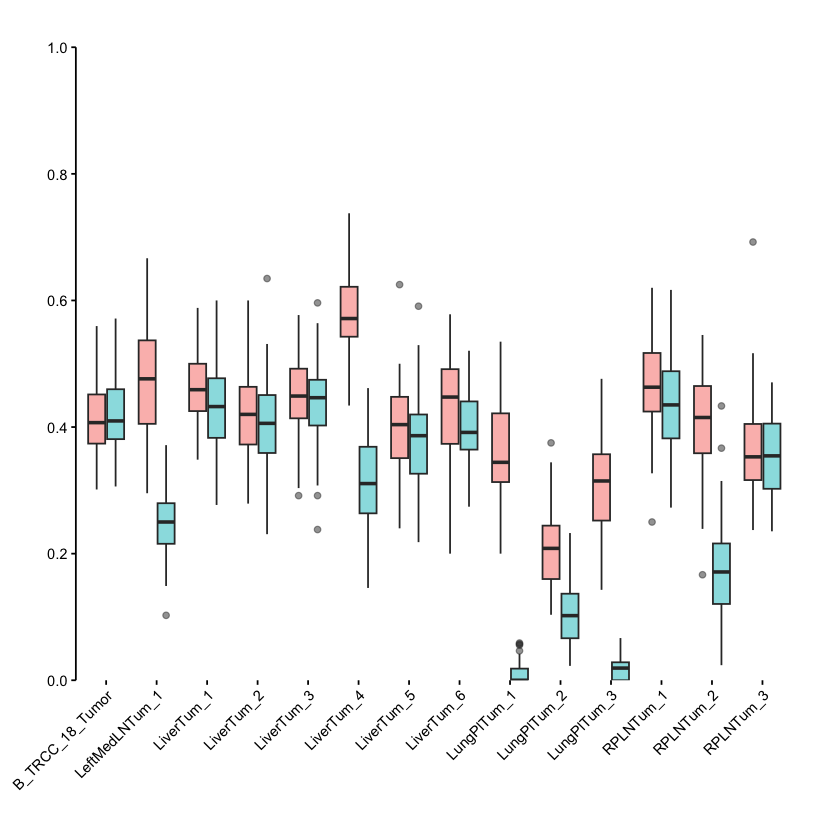

In [498]:
# plot boxplot of AF on chrX from the CNV breakpoint to the end of chrX
## select SNVs from the CNV breakpoint to the end of chrX
chrX_truncal_del <- rownames(chrX_truncal_af_ma)[38:nrow(chrX_truncal_af_ma)]
chrX_truncal_del_af_ldt <- af_ldt[chr_pos %in% chrX_truncal_del]
## select truncal SNVs that are not present in lung samples on chrX
lung_chrX_truncal_filtered_dt <- data.table(chr_pos = names(lung_chrX_truncal_filtered), 
                                            SNV = lung_chrX_truncal_filtered)
lung_chrX_truncal_filtered_dt <- unique(lung_chrX_truncal_filtered_dt)
## map the SNVs to their AF and reorder them
chrX_truncal_del_af_ldt <- merge(chrX_truncal_del_af_ldt, lung_chrX_truncal_filtered_dt, by = 'chr_pos', sort = FALSE)
## Categorize SNVs into two groups based on their presence (1) or absence (0) in lung samples
chrX_truncal_del_af_ldt <- chrX_truncal_del_af_ldt[, SNV := factor(ifelse(SNV, 1, 0), levels = c(1, 0))]
## plot boxplot for each group
(chrX_truncal_del_af_p <- ggplot() + 
    geom_boxplot(aes(x = variable, y = value, fill = SNV), 
    data = chrX_truncal_del_af_ldt, alpha = 0.5, show.legend = FALSE) + 
    scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2),
    expand = expansion(mult = c(0, 0))) + 
    theme(plot.margin = unit(c(1, 1, 1, 1), 'cm'), plot.background = element_blank(),
    axis.line.y = element_line(color = 'black', linewidth  = 0.5), 
    axis.ticks = element_line(color = 'black', linewidth  = 0.5), 
    axis.text = element_text(color = 'black'), axis.title = element_blank(), 
    axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
    panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
    panel.background = element_blank()))

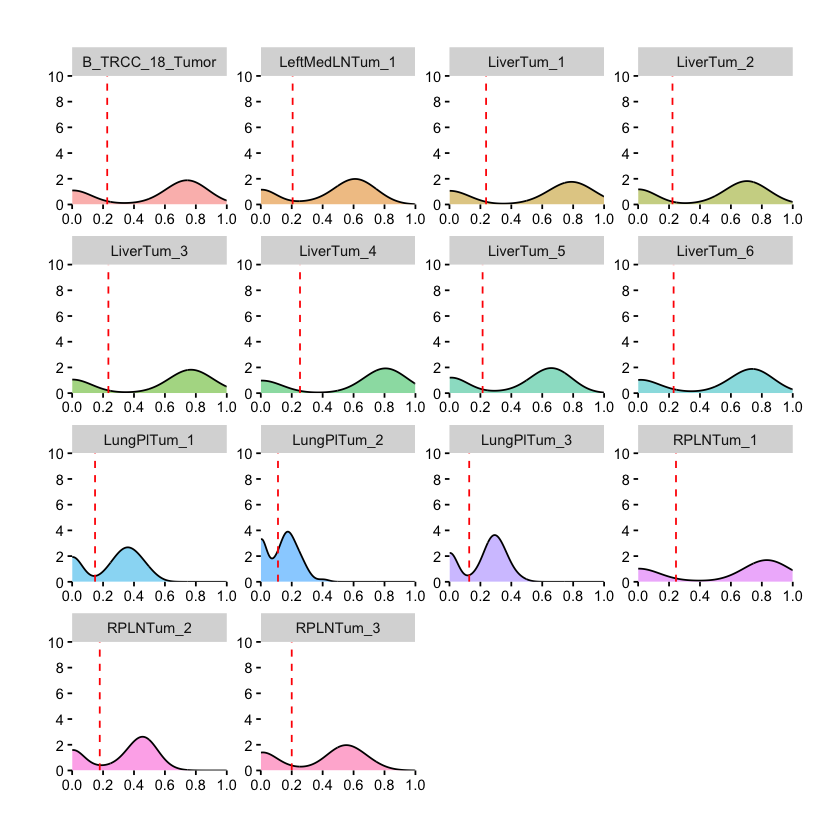

In [392]:
# plot allelic fraction distribution for all SNVs on chr9
chr9_af_ldt <- af_ldt[chr_pos %like% 'chr9_']
(chr9_af_p <- AF_density(chr9_af_ldt, cutoff))

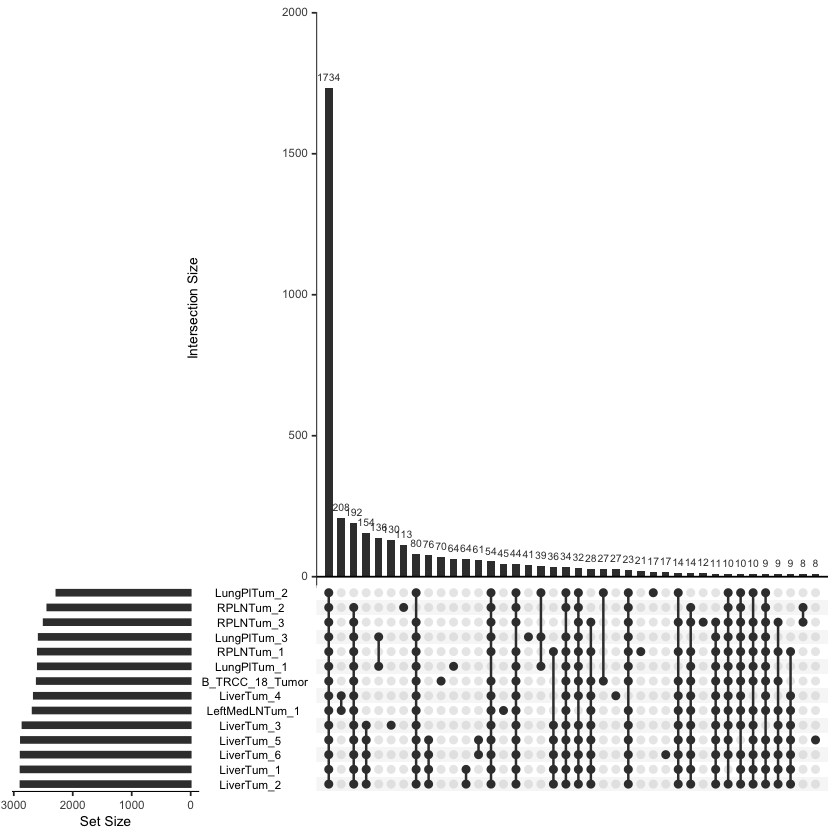

In [390]:
# upset plot for all SNVs
(filtered_upset <- upset(filtered_dt, sets = colnames(filtered_dt)[-1], order.by = 'freq'))

In [593]:
# count number of mutations in each pattern of upset

## make a copy of filtered snv table
pattern_dt <- copy(filtered_dt)
pattern_N_dt <- copy(filtered_dt)
## remove unnecessary columns
pattern_dt[, chr_pos := NULL]
pattern_dt[, B_TRCC_18_Tumor := NULL]
pattern_N_dt[, B_TRCC_18_Tumor := NULL]
## sample_id
sample_met <- colnames(pattern_dt)
## extract unique patterns and add ID
pattern_dt <- unique(pattern_dt)
## extract patterns with shared SNVs
pattern_dt <- pattern_dt[rowSums(pattern_dt) > 1]
## generate pattern_id
pattern_dt[, pattern_id := paste0('pattern_', 1:nrow(pattern_dt))]
setcolorder(pattern_dt, c('pattern_id', sample_met))
## count number of SNVs in each pattern
pattern_N_dt <- merge(pattern_N_dt, pattern_dt, by = sample_met)
pattern_N_dt <- pattern_N_dt[, .N, by = .(pattern_id)]
## annotate N with the patterns
pattern_N_dt <- merge(pattern_N_dt, pattern_dt, by = 'pattern_id')
colnames(pattern_N_dt)[colnames(pattern_N_dt) == 'N'] <- 'N_observed'
setorder(pattern_N_dt, -N_observed)
### selected SNV patterns
selected <- '~/Dropbox (Partners HealthCare)/projects/Kidney_Cancer_Translocation/TRCC18/FinalData/SNV_ptree_ma/TRCC18.ptree.selected_pattern.tsv'
selected_dt <- fread(selected)
selected_dt <- merge(pattern_dt, selected_dt, by = sample_met)
setcolorder(selected_dt, c('pattern_id', sample_met))


In [594]:
# estimation of FPR / FNR

## select truncal SNVs
### select disomic chromosomes
disomic_chr <- paste0('chr', c(2, 3, 5, 10, 12, 15, 16, 19))
### remove primary tumor from the snv binary matrix
filtered_met_ma <-filtered_ma
### generate a table with total number of positive mutations (N_PASS)
snv_met_dt <- data.table(chr_pos = rownames(filtered_met_ma), 
                         filtered_met_ma, 
                         N_pass = rowSums(filtered_met_ma))
snv_met_dt[, c('chr', 'pos') := tstrsplit(chr_pos, '_', fixed=TRUE)]
### select SNVs present in no less than 9 samples on disomic chromosomes
truncal_met_dt <- snv_met_dt[chr %in% disomic_chr]
truncal_met_dt <- truncal_met_dt[(N_pass >=9) & (N_pass <=14)]

## determine FPR and FNR
### keep all samples
sample_dt <- data.table(sample = colnames(filtered_met_ma))
### TP is determined by number of truncal SNVs
TP_dt <- truncal_met_dt[, sum(.N), by = .(chr)]
colnames(TP_dt)[2] <- 'TP'
### FN is determined by number of missed SNVs in each sample
FN_dt <- truncal_met_dt[(N_pass < 14)]
FN_dt[, c('chr_pos', 'N_pass') := NULL]
FN_dt <- melt(data = FN_dt, id.vars=c('chr', 'pos'), 
      variable.name = 'sample', value.name = 'SNV_observed')
FN_dt <- FN_dt[SNV_observed == 0, sum(.N), by = .(chr, sample)]
colnames(FN_dt)[3] <- 'FN'
### FNR
FNR_dt <- merge(TP_dt, FN_dt, by = 'chr')
FNR_dt <- FNR_dt[ ,FNR := FN / TP] # It's slightly different from the classic definition because the 'ground truth' could be inferred from the ptree
FNR_dt <- FNR_dt[, lapply(.SD, mean), by = .(sample), .SDcols = c('FNR')]
### If a sample has no FNR, use the minimum FNR
FNR_min <- min(FNR_dt$FNR)
FNR_dt <- merge(FNR_dt, sample_dt, by = 'sample', all = TRUE)
FNR_dt[is.na(FNR), 'FNR'] <- FNR_min
### FPR
FPR <- 0.01
### errors rates
error_dt <- copy(FNR_dt)
error_dt[, TPR := 1 - FNR]
error_dt[, `:=` (FPR = FPR, TNR = 1 - FPR)]

## MLE
### use MLE to optimize each selected pattern
MLE_dt <- MLE_pattern(pattern = selected_dt, error = error_dt)


In [595]:
# reassign SNVs

## MLE
### convert the table of optimzed model, model_id-sample matrix for models determined by MLE
MLE_model_dt <- dcast(data=MLE_dt, model_id ~ sample, value.var = 'model')
### use MLE to optimize each pattern
MLEop_dt <- MLE_pattern(pattern = pattern_dt, model = MLE_model_dt, error = error_dt)
### generate a model,pattern-sample matrix with observed patterns
MLEop_pattern_dt <- dcast(data=MLEop_dt, model_id + pattern_id ~ sample, value.var = 'pattern')

## count survival rate
### make new dt with label
MLE_model_ML_dt <- copy(MLE_model_dt)
colnames(MLE_model_ML_dt)[colnames(MLE_model_ML_dt) == 'model_id'] <- 'model_ML'
### annotate patterns with optimized models
MLEop_pattern_dt <- merge(MLEop_pattern_dt, MLE_model_ML_dt, by = sample_met, all = TRUE)
### annotate patterns with number of SNVs
MLEop_pattern_dt <- merge(MLEop_pattern_dt, pattern_N_dt, by = c('pattern_id', sample_met), all = TRUE)
### order by N of observed SNVs
setcolorder(MLEop_pattern_dt, c('pattern_id', 'model_id', 'model_ML', 'N_observed', sample_met))
setorder(MLEop_pattern_dt, -N_observed)
### group by model_id
MLEop_pattern_dt <- MLEop_pattern_dt[, .SD, by = model_id]


In [596]:

# output tables
## Number of SNVs in each pattern
fwrite(pattern_N_dt, paste0(o, "pattern.N.tsv"), sep = "\t")
## Optimized models generated from MLE
fwrite(MLE_dt, paste0(o, "MLE.tsv"), sep = "\t")
## SNVs assigned in optimized models
fwrite(MLEop_dt, paste0(o, "MLEop.tsv"), sep = "\t")
## Models in optimized models
fwrite(MLEop_pattern_dt, paste0(o, "MLEop.pattern.tsv"), sep = "\t")


pdf 
  2

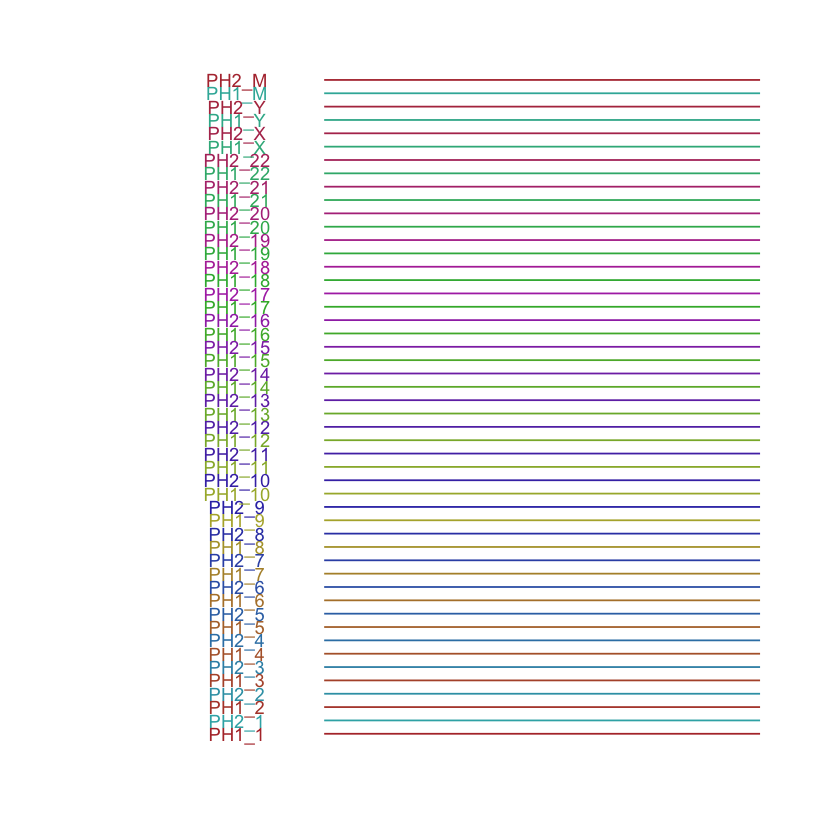

In [720]:
 map <- c()
 ### chromosomes in HSB
 hue <- c(seq(0, 0.99, length.out = 50))  # Adjusted Hue values (range: 0 to 1)
 chr_hex <- hsv(hue, 0.7, 0.7)
 names(chr_hex) <- c(paste0('PH1_', c(1:22, 'X', 'Y', 'M')), 
                     paste0('PH2_', c(1:22, 'X', 'Y', 'M')))

chr_dt <- data.table(chr = names(chr_hex), col = chr_hex)
chr_dt <- chr_dt[, chr0 := gsub('.*_', '', chr)]
chr_dt <- chr_dt[, chr0 := gsub('X', '23', chr0)]
chr_dt <- chr_dt[, chr0 := gsub('Y', '24', chr0)]
chr_dt <- chr_dt[, chr0 := gsub('M', '25', chr0)]
chr_dt <- chr_dt[, chr0 := as.numeric(chr0)]
chr_dt <- chr_dt[chr %like% 'PH2_', chr0 := chr0 + 0.5]
setorder(chr_dt, chr0, chr)

(chr_density_p <- ggplot(aes(x = 1, y = chr0, xend = 2, yend = chr0, color=col, label = chr),
                         data = chr_dt) + 
    geom_segment() + 
    scale_color_identity() + 
    geom_text(hjust = 'outside', nudge_x = -0.2) + 
    xlim(0.5, 2) + 
    theme(plot.margin = unit(c(1, 1, 1, 1), 'cm'), plot.background = element_blank(),
     axis.line = element_blank(), 
     axis.ticks = element_blank(), 
     axis.text = element_blank(), 
     panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     panel.background = element_blank()) + 
    xlab('') + ylab(''))

pdf(paste0(o, 'chr.density.pdf'), pw, ph, useDingbats=FALSE)
chr_density_p
dev.off()


In [393]:
pdf(paste0(o, 'AF.pdf'), pw, ph, useDingbats=FALSE)
af_p
dev.off()

pdf(paste0(o, 'truncal_AF.pdf'), pw, ph, useDingbats=FALSE)
truncal_af_p
dev.off()

pdf(paste0(o, 'chr2.AF.pdf'), pw, ph, useDingbats=FALSE)
chr2_af_p
dev.off()

pdf(paste0(o, 'chr2.truncal_AF.pdf'), pw, ph, useDingbats=FALSE)
chr2_truncal_af_p
dev.off()

pdf(paste0(o, 'chrX.AF.pdf'), pw, ph, useDingbats=FALSE)
chrX_af_p
dev.off()

pdf(paste0(o, 'chrX.truncal_AF.pdf'), pw, ph, useDingbats=FALSE)
chrX_truncal_af_p
dev.off()

pdf(paste0(o, 'chrX.truncal_AF.heatmap.pdf'), 8, 3, useDingbats=FALSE)
draw(chrX_truncal_af_h, heatmap_legend_side = "bottom")
dev.off()

pdf(paste0(o, 'chr9.truncal_AF.pdf'), pw, ph, useDingbats=FALSE)
chr9_af_p
dev.off()

pdf(paste0(o, 'chr.density.pdf'), pw, ph, useDingbats=FALSE)
chr_density_p
dev.off()

pdf(paste0(o, 'disomy.bar.pdf'), pw, ph, useDingbats=FALSE)
truncal_bar_p
dev.off()

pdf(paste0(o, 'chr2.bar.pdf'), pw, ph, useDingbats=FALSE)
chr2_bar_p
dev.off()




pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

In [497]:
pdf(paste0(o, 'chrX.truncal_AF.heatmap.pdf'), 8, 3, useDingbats=FALSE)
draw(chrX_truncal_af_h, heatmap_legend_side = "bottom")
dev.off()

pdf(paste0(o, 'chrX.chrX_truncal_del_af_p.box.pdf'), 8, 5, useDingbats=FALSE)
chrX_truncal_del_af_p
dev.off()

pdf 
  2

pdf 
  2

In [ ]:
pdf(paste0(o, 'upset.pdf'), 10, ph, useDingbats=FALSE)
filtered_upset
dev.off()